In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [7]:
# Add project path
sys.path.insert(0, '/home/dmullane/SrivatsanLab/Dustin/organism_scale_modelling')

# Import only what we need, define rest locally
from scripts.embeddings.plot_all_clusterings import COG_COLORS
import pandas as pd

def load_umap_embedding(n_neighbors=15, subsample=1000000, path=None):
    """Load UMAP embedding."""
    if path==None:
        umap_file = f'../results/umap/umap_n{n_neighbors}_subsample{subsample}.npz'
    else:
        umap_file = path
    data = np.load(umap_file, allow_pickle=True)
    return data['umap_embedding'], data['gene_ids'], data['genome_ids']


def load_cog_annotations_for_genes(gene_ids, genome_ids):
    """Load COG annotations for genes - FIXED VERSION."""
    print("Loading COG annotations...")
    
    # Load COG database files
    cog_db_dir = Path('/fh/fast/srivatsan_s/grp/SrivatsanLab/Sanjay/databases/cog')
    cog_csv_file = cog_db_dir / 'cog-20.cog.csv'
    cog_def_file = cog_db_dir / 'cog-20.def.tab'
    
    # Load protein → COG mapping
    print(f"  Loading protein→COG mapping...")
    prot_to_cog = {}
    with open(cog_csv_file, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            fields = line.strip().split(',')
            if len(fields) >= 7:
                prot_id = fields[2]
                cog_id = fields[6]
                if prot_id not in prot_to_cog:
                    prot_to_cog[prot_id] = cog_id
    print(f"    Loaded {len(prot_to_cog):,} protein→COG mappings")
    
    # Load COG → category mapping
    print(f"  Loading COG→category mapping...")
    cog_def = pd.read_csv(cog_def_file, sep='\t', header=None, encoding='latin-1',
                         names=['cog_id', 'category', 'description', 'gene', 'pathway', 'extra1', 'extra2'])
    cog_to_category = dict(zip(cog_def['cog_id'], cog_def['category']))
    print(f"    Loaded {len(cog_to_category):,} COG→category mappings")
    
    # Get unique genomes
    unique_genomes = set(genome_ids)
    gene_id_set = set(gene_ids)
    diamond_dir = Path('../results/functional_annotation')
    cog_lookup = {}
    
    print(f"  Processing {len(unique_genomes)} genomes...")
    n_processed = 0
    for genome_id in unique_genomes:
        hit_file = diamond_dir / f'{genome_id}_cog_diamond' / f'{genome_id}_cog_hits.tsv'
        
        if not hit_file.exists():
            continue
        
        try:
            hits_df = pd.read_csv(hit_file, sep='\t',
                                 names=['gene_id', 'protein_id', 'pident', 'length', 'mismatch',
                                       'gapopen', 'qstart', 'qend', 'sstart', 'send',
                                       'evalue', 'bitscore', 'qcovhsp', 'scovhsp'])
            
            hits_df = hits_df[hits_df['gene_id'].isin(gene_id_set)]
            
            for gene_id, group in hits_df.groupby('gene_id'):
                best_hit = group.iloc[0]
                protein_id = best_hit['protein_id']
                
                if pd.notna(protein_id):
                    # Convert underscore to dot
                    if '_' in str(protein_id):
                        parts = str(protein_id).rsplit('_', 1)
                        protein_id_dot = f"{parts[0]}.{parts[1]}"
                    else:
                        protein_id_dot = str(protein_id)
                    
                    # Map protein → COG → category
                    if protein_id_dot in prot_to_cog:
                        cog_id = prot_to_cog[protein_id_dot]
                        if cog_id in cog_to_category:
                            categories = cog_to_category[cog_id]
                            if len(categories) > 0 and categories[0] != '-':
                                cog_lookup[gene_id] = categories[0]
            
            n_processed += 1
            if n_processed % 1000 == 0:
                print(f"    Processed {n_processed}/{len(unique_genomes)} genomes, found {len(cog_lookup):,} annotations...")
                
        except Exception as e:
            print(f"    Warning: Could not load {genome_id}: {e}")
            continue
    
    n_annotated = len(cog_lookup)
    pct_annotated = 100 * n_annotated / len(gene_ids)
    print(f"  Final: {n_annotated:,} / {len(gene_ids):,} genes annotated ({pct_annotated:.1f}%)")
    
    return cog_lookup


def align_clustering_to_umap(cluster_labels, cluster_gene_ids, umap_gene_ids):
    """Align clustering labels to UMAP gene order."""
    gene_to_cluster = dict(zip(cluster_gene_ids, cluster_labels))
    aligned_labels = np.array([gene_to_cluster.get(gid, -1) for gid in umap_gene_ids])
    return aligned_labels


def map_cogs_to_genes(gene_ids, cog_lookup):
    """Map COG categories to gene IDs."""
    cog_categories = np.array([cog_lookup.get(gid, 'No COG') for gid in gene_ids])
    n_annotated = (cog_categories != 'No COG').sum()
    pct_annotated = 100 * n_annotated / len(cog_categories)
    print(f"  COG mapping: {pct_annotated:.1f}% ({n_annotated:,}/{len(cog_categories):,})")
    return cog_categories


def plot_clustering_with_cog_notebook(umap_coords, cluster_labels, cog_categories,
                                       clustering_name, n_neighbors, output_file=None):
    """Create a figure with 2 subplots: clusters and COG annotations."""
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # LEFT: Clusters
    ax = axes[0]
    mask_noise = cluster_labels == -1
    mask_clustered = ~mask_noise
    
    if np.any(mask_noise):
        ax.scatter(umap_coords[mask_noise, 0], umap_coords[mask_noise, 1],
                   c='lightgray', s=0.1, alpha=0.3, rasterized=True)
    if np.any(mask_clustered):
        ax.scatter(umap_coords[mask_clustered, 0], umap_coords[mask_clustered, 1],
                   c=cluster_labels[mask_clustered], s=0.5, alpha=0.5, 
                   cmap='tab20', rasterized=True)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = np.sum(mask_noise)
    ax.set_title(f'{clustering_name}\\n{n_clusters:,} clusters, {n_noise:,} noise ({100*n_noise/len(cluster_labels):.1f}%)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(f'UMAP 1 (n_neighbors={n_neighbors})', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.grid(True, alpha=0.2)
    
    # RIGHT: COG Categories  
    ax = axes[1]
    for cog, color in COG_COLORS.items():
        mask = cog_categories == cog
        if mask.sum() > 0:
            ax.scatter(umap_coords[mask, 0], umap_coords[mask, 1],
                       c=color, s=0.5, alpha=0.3, label=cog, rasterized=True)
    
    n_annotated = (cog_categories != 'No COG').sum()
    pct_annotated = 100 * n_annotated / len(cog_categories)
    ax.set_title(f'COG Categories\\n{pct_annotated:.1f}% annotated ({n_annotated:,}/{len(cog_categories):,})',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel(f'UMAP 1 (n_neighbors={n_neighbors})', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.grid(True, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, markerscale=3)
    
    plt.tight_layout()
    if output_file:
        output_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        print(f"  Saved: {output_file}")
    
    return fig

print("✓ All functions loaded successfully")

✓ All functions loaded successfully


In [3]:
df = pd.read_csv('../results/clustering/leiden_sweep_summary.csv').dropna()
df = df[df['n_clusters']>1000]
df.sort_values('pct_clusters_hom>=0.7',ascending=False)

,file,resolution,n_neighbors,cog_only,n_clusters,n_genes,mean_homogeneity,weighted_homogeneity,annotation_rate,median_homogeneity,...,n_genes_hom>=0.9,pct_genes_hom>=0.9,n_clusters_hom>=0.95,pct_clusters_hom>=0.95,n_genes_hom>=0.95,pct_genes_hom>=0.95,n_clusters_hom>=1.0,pct_clusters_hom>=1.0,n_genes_hom>=1.0,pct_genes_hom>=1.0
14,clusters_leiden_res1000_nn200_cogonly.npz,1000.0,200,True,35870,798416,0.656088,0.495284,1.000000,0.625000,...,77759.0,9.739159,13918.0,38.801227,52778.0,6.610338,13634.0,38.009479,26290.0,3.292770
12,clusters_leiden_res1000_nn15_cogonly.npz,1000.0,15,True,17797,798416,0.571928,0.591639,1.000000,0.534884,...,165374.0,20.712761,2195.0,12.333539,113579.0,14.225542,1093.0,6.141485,51076.0,6.397166
112,clusters_leiden_res750_nn15_cogonly.npz,750.0,15,True,14483,798416,0.565443,0.574234,1.000000,0.525424,...,150217.0,18.814377,1789.0,12.352413,105122.0,13.166319,857.0,5.917282,44379.0,5.558381
82,clusters_leiden_res500_nn15_cogonly.npz,500.0,15,True,10856,798416,0.556296,0.548924,1.000000,0.511111,...,136174.0,17.055520,1334.0,12.288136,90716.0,11.361997,632.0,5.821665,36021.0,4.511558
72,clusters_leiden_res400_nn15_cogonly.npz,400.0,15,True,9209,798416,0.552673,0.535647,1.000000,0.504425,...,126162.0,15.801537,1143.0,12.411771,84498.0,10.583205,545.0,5.918124,33397.0,4.182907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,clusters_leiden_res300_nn200_all.npz,300.0,200,False,4439,1000000,0.375288,0.364231,0.798416,0.305556,...,32774.0,3.277400,170.0,3.829691,18289.0,1.828900,137.0,3.086281,4822.0,0.482200
43,clusters_leiden_res200_nn200_all.npz,200.0,200,False,2823,1000000,0.356550,0.342381,0.798416,0.285124,...,24799.0,2.479900,84.0,2.975558,13095.0,1.309500,62.0,2.196245,1449.0,0.144900
19,clusters_leiden_res100_nn100_all.npz,100.0,100,False,1518,1000000,0.351564,0.332615,0.798416,0.280713,...,29976.0,2.997600,27.0,1.778656,14329.0,1.432900,4.0,0.263505,1550.0,0.155000
24,clusters_leiden_res100_nn200_cogonly.npz,100.0,200,True,1357,798416,0.348918,0.332264,1.000000,0.280193,...,16513.0,2.068220,40.0,2.947679,11724.0,1.468407,24.0,1.768607,250.0,0.031312


<Axes: xlabel='resolution', ylabel='n_clusters'>

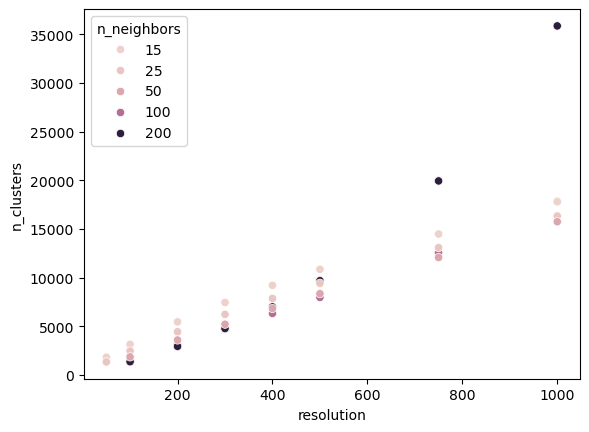

In [25]:
# sns.barplot(data=df[df['cog_only']==True], x='resolution', y='n_clusters', hue='n_neighbors')
sns.scatterplot(data=df[df['cog_only']==True], x='resolution', y='n_clusters', hue='n_neighbors')


<Axes: xlabel='resolution', ylabel='mean_homogeneity'>

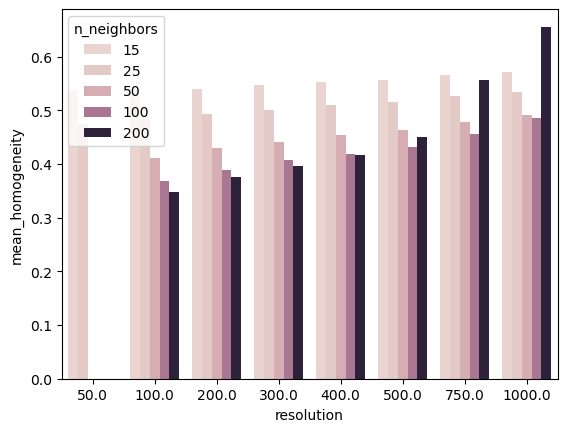

In [26]:
sns.barplot(data=df[df['cog_only']==True], x='resolution', y='mean_homogeneity', hue='n_neighbors')


<Axes: xlabel='resolution', ylabel='pct_clusters_hom>=0.9'>

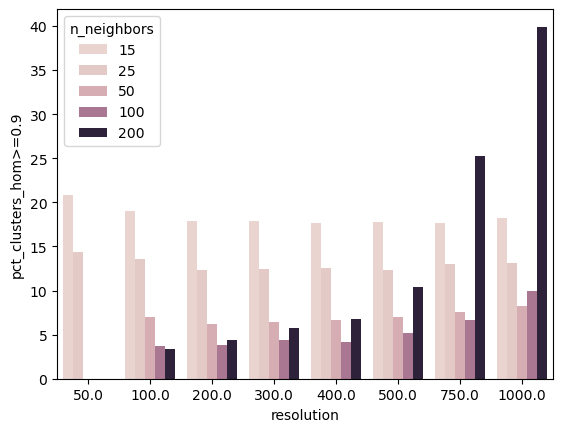

In [28]:
sns.barplot(data=df[df['cog_only']==True], x='resolution', y='pct_clusters_hom>=0.9', hue='n_neighbors')


<Axes: xlabel='resolution', ylabel='pct_clusters_hom>=0.7'>

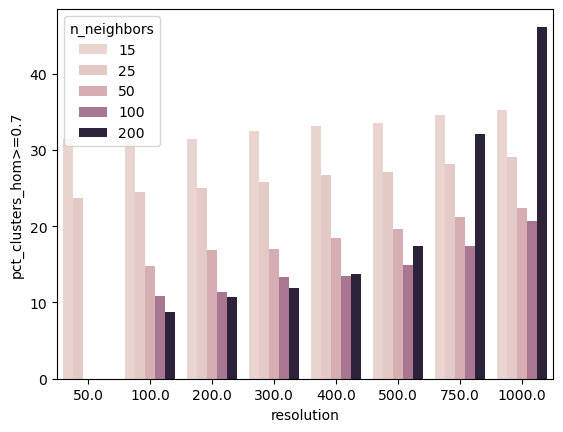

In [29]:
sns.barplot(data=df[df['cog_only']==True], x='resolution', y='pct_clusters_hom>=0.7', hue='n_neighbors')


Loaded: clusters_leiden_res1000_nn15_cogonly.npz
  Clusters: 17,797
  Genes in clustering: 798,416

  Genes in UMAP: 1,000,000

  Aligned labels: 1,000,000
  Genes in clusters: 798,416
  Genes as noise: 201,584

Loading COG annotations...
  Loading protein→COG mapping...
    Loaded 3,213,025 protein→COG mappings
  Loading COG→category mapping...
    Loaded 4,877 COG→category mappings
  Processing 7664 genomes...
    Processed 1000/7664 genomes, found 103,458 annotations...
    Processed 2000/7664 genomes, found 207,455 annotations...
    Processed 3000/7664 genomes, found 312,020 annotations...
    Processed 4000/7664 genomes, found 414,793 annotations...
    Processed 5000/7664 genomes, found 519,203 annotations...
    Processed 6000/7664 genomes, found 623,560 annotations...
    Processed 7000/7664 genomes, found 728,323 annotations...
  Final: 798,416 / 1,000,000 genes annotated (79.8%)
  COG mapping: 79.8% (798,416/1,000,000)

  Saved: ../results/plots/notebook/leiden_res1000_nn15_

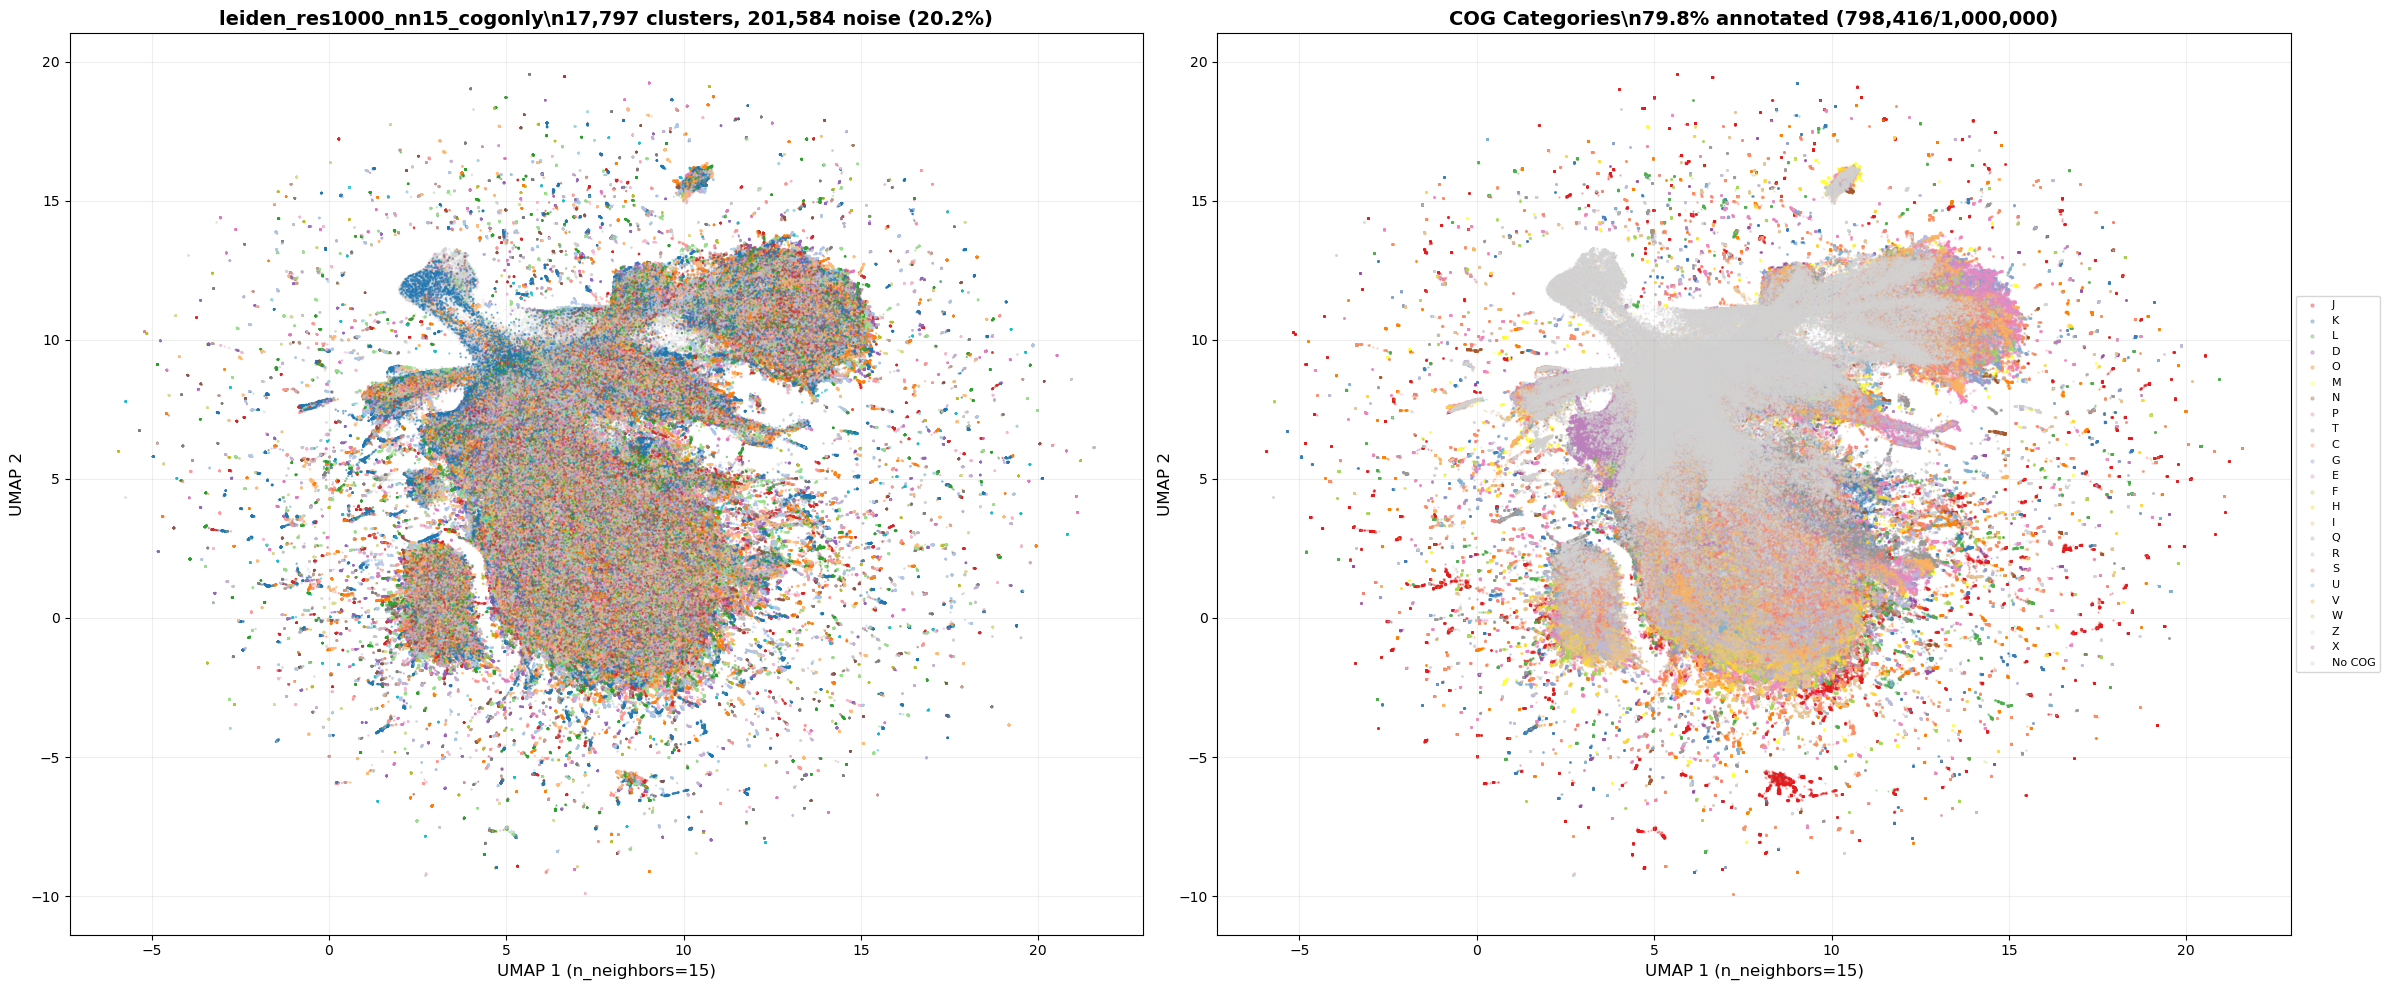

In [8]:
# Example: Plot a specific clustering result with COG annotations

# Choose which clustering to plot
clustering_file = 'clusters_leiden_res1000_nn15_cogonly.npz'
umap_n_neighbors = 15  # Which UMAP to use (15, 25, 50, 100, or 200)
umap_path = '../results/umap/umap_n15_subsample1000000.npz'

# Load the clustering result
clustering_path = Path('../results/clustering') / clustering_file
data = np.load(clustering_path, allow_pickle=True)

cluster_labels = data['labels']
cluster_gene_ids = data['gene_ids']
cluster_genome_ids = data['genome_ids']
n_clusters = data['n_clusters']

print(f"Loaded: {clustering_file}")
print(f"  Clusters: {n_clusters:,}")
print(f"  Genes in clustering: {len(cluster_gene_ids):,}")
print()

# Load UMAP coordinates (may have more genes than clustering)
umap_coords, umap_gene_ids, umap_genome_ids = load_umap_embedding(path=umap_path)
print(f"  Genes in UMAP: {len(umap_gene_ids):,}")
print()

# Align clustering labels to UMAP gene order
aligned_labels = align_clustering_to_umap(cluster_labels, cluster_gene_ids, umap_gene_ids)
print(f"  Aligned labels: {len(aligned_labels):,}")
print(f"  Genes in clusters: {(aligned_labels != -1).sum():,}")
print(f"  Genes as noise: {(aligned_labels == -1).sum():,}")
print()

# Load COG annotations
cog_lookup = load_cog_annotations_for_genes(umap_gene_ids, umap_genome_ids)
cog_categories = map_cogs_to_genes(umap_gene_ids, cog_lookup)
print()

# Create the plot
clustering_name = clustering_file.replace('clusters_', '').replace('.npz', '')
output_file = Path('../results/plots/notebook') / f'{clustering_name}_umap_n{umap_n_neighbors}.png'
output_file.parent.mkdir(parents=True, exist_ok=True)

plot_clustering_with_cog_notebook(
    umap_coords=umap_coords,
    cluster_labels=aligned_labels,
    cog_categories=cog_categories,
    clustering_name=clustering_name,
    n_neighbors=umap_n_neighbors,
    output_file=output_file
)

plt.show()